# Can your yearly compensation be predicted?

# Content
* [Introduction](#intro)
* [Reorganizing data](#sort)
* [Finding best predictors](#best)
* [Determining relation between predictors and yearly compensation](#mach)
* [Conclusions](#concl)

<a id='intro'></a>
# Introduction

It is commonly believed that a person's salary will improve depending on different factors. For example, it is said that a higher degree of formal education will positively impact your income. Likewise, people affirm that your salary will grow if you have more years of work experience. 

Kaggle 2018 dataset contains a lot of information collected from data scientists around the world. Among all the data, there is information related with current yearly compensation, years of experience, highest level of formal education attained and age. Therefore, this dataset can give insights into the relation that exists between people salary and other information. 

The goal of this job is to find a relation between data scientists yearly compensation and information such as age, years of experience and the highest level of formal education. To achieve this goal, the kaggle dataset is reorganized to get numerical predictors first. Then, data scientists are divided according to their salary in two groups: those with more and those with less salary than a provided number. This is done in order to get a classification problem with two possible classes for the target variable (yearly compensation). After that, variables that best predict the salary are found with ROC and precision-recall figures. Finally, machine learning methods, including logistic regression, are implemented to find a relation between these variables and yearly compensation.

<a id='sort'></a>
# Reorganizing data

In [1]:
# Importing neccesary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate
import itertools
import sklearn.model_selection
import sklearn.linear_model
%matplotlib inline

In [2]:
# Read data
data=pd.read_csv("multipleChoiceResponses.csv",skiprows=[1],low_memory=False)

# Predictors and target
predictors=['Q2','Q4','Q8']
target='Q9'

n_data=data[[target]+predictors].dropna()

In [3]:
# Adjust age, taking lower age in age range as parameter
age='Q2'
orig_age=np.array(n_data[age])
n_ages=np.zeros(len(orig_age))

for i in range(len(orig_age)):
    if "-" in orig_age[i]:
        str_age=orig_age[i].split("-")[0]
    else:
        str_age=orig_age[i].replace("+","")
    n_ages[i]=int(str_age)
    
n_data[age]=n_ages

In [4]:
# Adjust experience years, taking lower experience years in years range as parameter
years='Q8'
orig_years=np.array(n_data[years])
n_years=np.zeros(len(orig_years))

for i in range(len(orig_years)):
    if "-" in orig_years[i]:
        str_years=orig_years[i].split("-")[0]
    else:
        str_years=orig_years[i].replace("+","")
    n_years[i]=int(str_years)
    
n_data[years]=n_years

In [5]:
# Adjust salary to binary 
orig_salary=n_data[target]

strings=(sorted(set(n_data[target])))
ii=np.array(n_data['Q9']==strings[len(strings)-1])
subset=np.array(n_data[[target]+predictors])[~ii,:]

for i in range(subset.shape[0]):
    if "-" in subset[i,0]:
        max_salary=subset[i,0].split("-")[1]
    else:
        max_salary=subset[i,0].replace("+","")
    
    max_salary=max_salary.replace(",","")
    
    subset[i,0]=int(max_salary)
    

# Create binary array. 1 for people with salary > cut_salary
q9_binary=np.zeros(subset.shape[0])
cut_salary=150000
q9_binary[subset[:,0]>cut_salary]=1

subset[:,0]=q9_binary

In [6]:
# Ajust degree to numerical data
def string2numeric(data):
    dic={}
    values=sorted(set(data))
    cont=0
    for value in values:
        dic[value]=cont
        cont+=1;
    numeric=[dic[item] for item in data]
    return numeric, dic

n_deg,n_deg_dic=string2numeric(subset[:,2])
subset[:,2]=n_deg

<a id='best'></a>
# Finding best predictors

In [15]:
# Find the most important predictors according to ROC and Precision-recall areas from logistic regression

'''
Function to find areas of ROC and precision-recall figures
'''
def roc_pr_areas(data_predictors,data_target, method):
    # Split in train and test
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(data_predictors,data_target, test_size=0.4)
    
    # 
    method.fit(X_train,Y_train)
    y_predict=method.predict_proba(X_test)[:,1]
    
    conf_matrix=np.zeros((2,2))
    
    threshold=np.linspace(0.1,0.8,100)
    pts_roc=np.zeros((len(threshold),2))
    pts_pr=np.zeros((len(threshold),2))
    
    for i in range(len(threshold)):
    
        for j in range(len(y_predict)):
            
            if y_predict[j]>threshold[i]:
                if Y_test[j]==1:
                    conf_matrix[0,0]+=1
                else:
                    # False positive
                    conf_matrix[0,1]+=1
            else:
                if Y_test[j]==0:
                    conf_matrix[1,1]+=1
                else: 
                    # False negative
                    conf_matrix[1,0]+=1
        
        tp=conf_matrix[0,0]
        fp=conf_matrix[0,1]
        tn=conf_matrix[1,1]
        fn=conf_matrix[1,0]
        # pts_roc= false positive rate, true positive rate = fp/(fp+tn), tp/(tp+fn)
        pts_roc[i,:]=fp/(fp+tn), tp/(tp+fn)
        
        # pts_pr= recall, precision = tp/tp+fn, tp/tp+fp
        pts_pr[i,:]=tp/(tp+fn), tp/(tp+fp)
    
    # compute the area under precision recall curve
    ii = np.argsort(pts_roc[:,0])
    iii=ii[0:10]
    roc_area=scipy.integrate.trapz(pts_roc[ii,1],pts_roc[ii,0])
    
    # compute the area under precision recall curve
    ii = np.argsort(pts_pr[0,:])
    pr_area=scipy.integrate.trapz(pts_pr[ii,1],pts_pr[ii,0])  
    
    return roc_area, pr_area
    
    
    
'''
Function to find variables that best predict the target
'''
def best_predictors(data_predictors,data_target, method, predictor_names):
    n_predictors=len(predictor_names)
    highest_roc_area=0
    highest_pr_area=0
    best_predictors=np.array([''])
    for i in range(n_predictors):
        combinations = itertools.combinations(np.arange(0,n_predictors), i+1)
        for comb in combinations:
            roc_area, pr_area= roc_pr_areas(data_predictors,data_target, method)
            #print('roc_area=', roc_area, 'for combination', predictor_names[list(comb)],  'and pr_area=', pr_area)
            if roc_area>highest_roc_area and pr_area>highest_pr_area:
                highest_roc_area=roc_area
                highest_pr_area=pr_area
                best_predictors=predictor_names[list(comb)]
                print("New predictors=",best_predictors)
    return best_predictors

In [19]:
data_predictors=subset[:,1:]
data_target=np.array(subset[:,0], dtype=int)
f = sklearn.linear_model.LogisticRegression(solver='lbfgs')
predictors=np.array(['Q2','Q4','Q8'])

n_predictors=best_predictors(data_predictors,data_target,f, predictors)
print('Best predictors:',n_predictors)

New predictors= ['Q2']
New predictors= ['Q4']
New predictors= ['Q8']
New predictors= ['Q2' 'Q4']
Best predictors: ['Q2' 'Q4']


<a id='mach'></a>
# Determining relation between predictors and yearly compensation

In [20]:
# Get predictor columns as dictionary and get best predictors from subset data
predictors_cols_dic={}
for i in range(len(predictors)):
    predictors_cols_dic[predictors[i]]=i
predictors_subset=subset[:,1:]
target_subset=np.array(subset[:,0],dtype=int)

# Get best predictors subset
ii=[predictors_cols_dic[name] for name in n_predictors]
best_subset=predictors_subset[:,ii]

In [21]:
# Find relation between best predictor and target
nf = sklearn.linear_model.LogisticRegression(solver='lbfgs')
nf.fit(best_subset,target_subset)
print("Coefficients: ",nf.coef_)

Coefficients:  [[ 0.08429333 -0.03071553]]


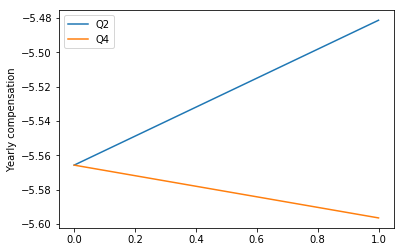

In [22]:
for i in range(nf.coef_.shape[1]):
    y=nf.intercept_+nf.coef_[:,i]
    plt.plot([0,1],[nf.intercept_,y],label=n_predictors[i])
plt.ylabel('Yearly compensation')
plt.legend()

<a id='concl'></a>
# Conclusions


After running multiple times the code, the set of best predictors can change, but always the same relations are found: yearly compensation grows with an increase in age and years of experience. On the other hand, yearly compensation decreases slowly with increments in the values for the highest degree of formal education, defined within the dictionary. This dictionary is as follows:

In [24]:
print(n_deg_dic)

{'Bachelor’s degree': 0, 'Doctoral degree': 1, 'I prefer not to answer': 2, 'Master’s degree': 3, 'No formal education past high school': 4, 'Professional degree': 5, 'Some college/university study without earning a bachelor’s degree': 6}


Based on this, the result is expected since greater values in the dictionary corresponds to lower levels of formal education. 